# Eulerian buckling of a beam

In this numerical tour, we will compute the critical buckling load of a straight beam under normal compression, the classical Euler buckling problem. Usually, buckling is an important mode of failure for slender beams so that a standard Euler-Bernoulli beam model is sufficient. However, since FEniCS does not support Hermite elements ensuring $C^1$-formulation for the transverse deflection, implementing such models is not straightforward and requires using advanced DG formulations for instance, see the `fenics-shell` [implementation of the Love-Kirchhoff plate model](http://fenics-shells.readthedocs.io/en/latest/demo/kirchhoff-love-clamped/demo_kirchhoff-love-clamped.py.html) or the [FEniCS documented demo on the biharmonic equation](http://fenics.readthedocs.io/projects/dolfin/en/2017.2.0/demos/biharmonic/python/demo_biharmonic.py.html).

As a result, we will simply formulate the buckling problem using a Timoshenko beam model.

## Timoshenko beam model formulation

We first formulate the stiffness bilinear form of the Timoshenko model given by:

$$k((w,\theta),(\widehat{w},\widehat{\theta}))= \int_0^L EI \dfrac{d\theta}{dx}\dfrac{d\widehat{\theta}}{dx} dx +  \int_0^L \kappa \mu S \left(\dfrac{dw}{dx}-\theta\right)\left(\dfrac{d\widehat{w}}{dx}-\widehat{\theta}\right) dx$$

where $I=bh^3/12$ is the bending inertia for a rectangular beam of width $b$ and height $h$, $S=bh$ the cross-section area, $E$ the material Young modulus and $\mu$ the shear modulus and $\kappa=5/6$ the shear correction factor. We will use a $P^2/P^1$ interpolation for the mixed field $(w,\theta)$. 

In [5]:
from dolfin import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

L = 10.
thick = Constant(0.03)
width = Constant(0.01)
E = Constant(70e3)
nu = Constant(0.)

EI = E*width*thick**3/12
GS = E/2/(1+nu)*thick*width
kappa = Constant(5./6.)


N = 100
mesh = IntervalMesh(N, 0, L) 

U = FiniteElement("CG", mesh.ufl_cell(), 2)
T = FiniteElement("CG", mesh.ufl_cell(), 1)
V = FunctionSpace(mesh, U*T)

u_ = TestFunction(V)
du = TrialFunction(V)
(w_, theta_) = split(u_)
(dw, dtheta) = split(du)


k_form = EI*inner(grad(theta_), grad(dtheta))*dx + \
         kappa*GS*dot(grad(w_)[0]-theta_, grad(dw)[0]-dtheta)*dx
l_form = Constant(1.)*u_[0]*dx

In [6]:
def both_ends(x, on_boundary):
    return on_boundary
def left_end(x, on_boundary):
    return near(x[0], 0) and on_boundary

bc = [DirichletBC(V.sub(0), Constant(0.), both_ends),
      DirichletBC(V.sub(1), Constant(0.), left_end)]

K = PETScMatrix()
assemble_system(k_form, l_form, bc, A_tensor=K)

(<dolfin.cpp.la.PETScMatrix at 0x7f454e3dbbf8>,
 <dolfin.cpp.la.Vector at 0x7f454e3dbf10>)

## Construction of the geometric stiffness matrix

The buckling analysis amounts to solving an eigenvalue problem of the form:

$$(\mathbf{K}+\lambda\mathbf{K_G})\mathbf{U} = 0$$

in which the geometric stiffness matrix $\mathbf{K_G}$ depends (linearly) on a prestressed state, the amplitude of which is represented by $\lambda$. The eigenvalue/eigenvector $(\lambda,\mathbf{U})$ solving the previous generalized eigenproblem respectively correspond to the critical buckling load and its associated buckling mode. For a beam in which the prestressed state correspond to a purely compression state of intensity $N_0>0$, the geometric stiffness bilinear form is given by:

$$k_G((w,\theta),(\widehat{w},\widehat{\theta}))= -\int_0^L N_0 \dfrac{dw}{dx}\dfrac{d\widehat{w}}{dx} dx$$

which is assembled below into the `KG` `PETScMatrix` (up to the negative sign).

In [7]:
N0 = Constant(1e-3)
kg_form = N0*dot(grad(w_), grad(dw))*dx
KG = PETScMatrix()
assemble(kg_form, tensor=KG)
for bci in bc:
    bci.zero(KG)

Note that we made use of the `zero` method of `DirichletBC` making the rows of the matrix associated with the boundary condition zero. If we used instead the `apply` method, the rows would have been replaced with a row of zeros with a 1 on the diagonal (as for the stiffness matrix `K`). As a result, we would have obtained an eigenvalue equal to 1 for each row with a boundary condition which can make more troublesome the computation of eigenvalues if they happen to be close to 1. Replacing with a full row of zeros in `KG` results in infinite eigenvalues for each boundary condition which is more suitable when looking for the lowest eigenvalues of the buckling problem.

##  Setting and solving the eigenvalue problem

Up to the negative sign cancelling from the previous definition of `KG`, we now formulate the generalized eigenvalue problem $\mathbf{KU}=-\lambda\mathbf{K_G U}$ using the `SLEPcEigenSolver`. The only difference from what has already been discussed in the dynamic modal analysis numerical tour is that buckling eigenvalue problem may be more difficult to solve than modal analysis in certain cases, it is therefore beneficial to prescribe a value of the spectral shift close to the critical buckling load.

Computing 3 first eigenvalues...


<IPython.core.display.Javascript object>


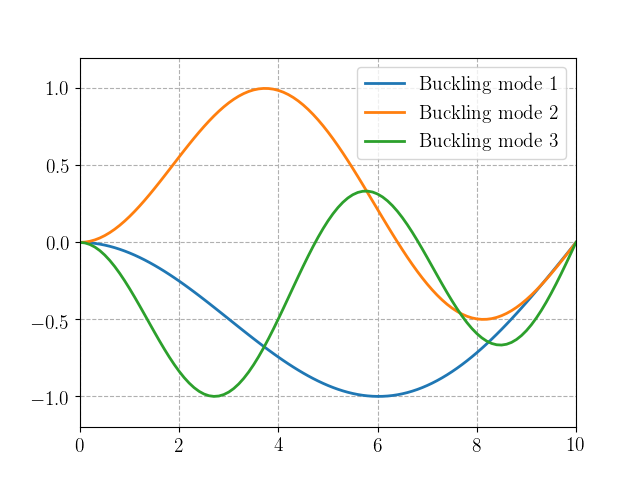

Critical buckling loads:
Exact:    0.31800  FE:    0.31805  Rel. gap 0.01%%
Exact:    0.93995  FE:    0.94033  Rel. gap 0.04%%
Exact:    1.87267  FE:    1.87415  Rel. gap 0.08%%


In [8]:
eigensolver = SLEPcEigenSolver(K, KG)
eigensolver.parameters['problem_type'] = 'gen_hermitian'
eigensolver.parameters['spectral_transform'] = 'shift-and-invert'
eigensolver.parameters['spectral_shift'] = 1e-3
eigensolver.parameters['tolerance'] = 1e-12

N_eig = 3   # number of eigenvalues
print("Computing %i first eigenvalues..." % N_eig)
eigensolver.solve(N_eig)

# Exact solution computation
from scipy.optimize import root
from math import tan
falpha = lambda x: tan(x)-x
alpha = lambda n: root(falpha, 0.99*(2*n+1)*pi/2.)['x'][0]

plt.figure()
# Extraction
print("Critical buckling loads:")
for i in range(N_eig):
    # Extract eigenpair
    r, c, rx, cx = eigensolver.get_eigenpair(i)
    
    critical_load_an = alpha(i+1)**2*float(EI/N0)/L**2
    print("Exact: {0:>10.5f}  FE: {1:>10.5f}  Rel. gap {2:1.2f}%%".format(
           critical_load_an, r, 100*(r/critical_load_an-1)))
    
    # Initialize function and assign eigenvector (renormalize by stiffness matrix)
    eigenmode = Function(V,name="Eigenvector "+str(i))
    eigenmode.vector()[:] = rx/np.max(np.abs(rx.get_local()))

    plot(eigenmode.sub(0), label="Buckling mode "+str(i+1))

plt.ylim((-1.2, 1.2))
plt.legend()
plt.show()

Above, we compared the computed FE critical loads with the known analytical value for the Euler-Bernoulli beam model and the considered boundary conditions given by:

$$F_n = (\alpha_n)^2 \dfrac{EI}{L^2} \quad \text{with }\alpha_n \text{ solutions to } \tan(\alpha) = \alpha$$

In particular, it can be observed that the displacement-based FE solution overestimates the exact buckling load and that the error increases with the order of the buckling load.